In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import math
from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# set the max columns to none
pd.set_option('display.max_columns', None)

# 1. Load data

In [380]:
df = pd.read_csv('../datasets/complete_data/df.csv')
df

,start MTU (UTC),Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
0,2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
1,2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2,2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
3,2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
4,2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
8756,2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
8757,2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0
8758,2022-12-31 22:00:00,119.98,23.56,119.98,4.84,1991.000000,989.0,585.0,69.0,0.0,814.0,2098.000000,13.0,443.0,35.0,183.0,814.0,23.0,1498.0,7.0,25.0,137.0,14.0,539.0,5796.0,0.0,1033.0,504.0,0.0,90.0,0.0,0.0,29.0,2119.0,0.0,5038234.0,1579000.0


In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   start MTU (UTC)                                                                8760 non-null   object 
 1   Day-ahead Price [EUR/MWh] BZN|NO1                                              8760 non-null   float64
 2   Day-ahead Price [EUR/MWh] BZN|NO3                                              8760 non-null   float64
 3   Day-ahead Price [EUR/MWh] BZN|NO5                                              8760 non-null   float64
 4   Day-ahead Price [EUR/MWh] BZN|SE3                                              8760 non-null   float64
 5   Actual Total Load [MW] - BZN|NO5                                               8760 non-null   float64
 6   Hydro Run-of-river and p

# 2. Preprocessing

#### 2.1 Indexing

In [382]:
df = df.set_index('start MTU (UTC)')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='start MTU (UTC)', length=8760, freq=None)

#### 2.2 Plotting 'Day-ahead Price BZN|NO1'

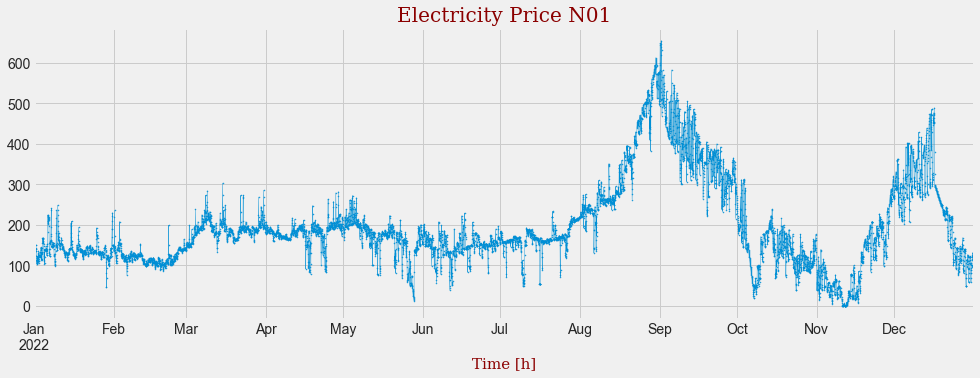

In [383]:
target_column = df['Day-ahead Price [EUR/MWh] BZN|NO1']
target_column_df =  pd.DataFrame(target_column)
target_column.plot( figsize=(15, 5), color=color_pal[0], lw=0.4, marker="." , markersize=1)

font1 = {'family':'serif','color':'darkred','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.title("Electricity Price N01", fontdict = font1)
plt.xlabel("Time [h]", fontdict = font2)
plt.show()

<AxesSubplot:ylabel='Frequency'>

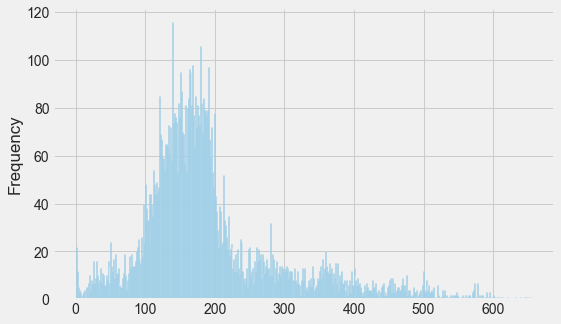

In [384]:
df['Day-ahead Price [EUR/MWh] BZN|NO1'].plot(kind='hist',figsize=(8, 5), bins=500)

In [385]:
df.query( '`Day-ahead Price [EUR/MWh] BZN|NO1` > 100.0 ')

,Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
start MTU (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0


#### 2.3 Dropping features

#### 2.4 Normalization and scaling

#### 2.5 PCA

#### 2.6 Feature engineering

###### 2.6.1 Create hour feature

In [386]:
def create_features (df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

###### 2.6.2 Create total import feature

###### 2.6.3 Create total export feature

###### 2.6.4 Create total load feature

#### 2.7  Visualize target and hour feature's relationship

In [387]:
"""
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=df, x='hour', y='Day-ahead Price [EUR/MWh] BZN|NO1')
ax.set_title('Price by Hour')
plt.show
"""

"\nfig, ax = plt.subplots(figsize=(10, 10))\nsns.boxplot(data=df, x='hour', y='Day-ahead Price [EUR/MWh] BZN|NO1')\nax.set_title('Price by Hour')\nplt.show\n"

# 3. Time series cross validation

### Removing symbols from feature names

In [388]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>'))) else col for col in df.columns.values]

In [389]:
TARGET = 'Day-ahead Price _EUR/MWh_ BZN|NO1'

FEATURES = [
    'Day-ahead Price _EUR/MWh_ BZN|NO3',
    'Day-ahead Price _EUR/MWh_ BZN|NO5',
    'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO1',
    'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
    'Hydro Pumped Storage Aggregated- BZN|NO2',
    'Hydro Run-of-river and poundage - BZN|NO2',
    'Hydro Water Reservoir - BZN|NO2',
    'Waste - BZN|NO2',
    'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
    'Hydro Run-of-river and poundage - BZN|NO3',
    'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
    'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
    'Hydro Pumped Storage Aggregated- BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
    'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
    'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
    'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
    'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
    'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
    'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3']

## 2. Create lag features
 We have to keep in mind that the lag feature can not be longer than our forecastinghorizon(24h).

In [390]:
# Function to create lagged dataset with 24 lag features for each input feature
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()

    # Adding lagged features for target variable

    lagged_df[f"{TARGET}_lag1"] = lagged_df[TARGET].shift(-1)

    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)

    # Creating a dataframe with lagged features with 24 steps for each of the original features
    for i in range(1, 25):
        for col in df.columns:
            lagged_col_name = f"{col}_lag{i}"
            lagged_df[lagged_col_name] = df[col].shift(i)

    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)

    return lagged_df
df = create_lagged_dataset(df)
df

C:\Users\Isak\AppData\Local\Temp\ipykernel_26092\1994767551.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_df[lagged_col_name] = df[col].shift(i)
C:\Users\Isak\AppData\Local\Temp\ipykernel_26092\1994767551.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_df[lagged_col_name] = df[col].shift(i)
C:\Users\Isak\AppData\Local\Temp\ipykernel_26092\1994767551.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Day-ahead Price _EUR/MWh_ BZN|NO1  \
start MTU (UTC)                                          
2022-01-02 00:00:00                             111.66   
2022-01-02 01:00:00                             106.53   
2022-01-02 02:00:00                             104.50   
2022-01-02 03:00:00                             104.06   
2022-01-02 04:00:00                             105.86   
...                                                ...   
2022-12-31 18:00:00                             125.44   
2022-12-31 19:00:00                             123.61   
2022-12-31 20:00:00                             121.09   
2022-12-31 21:00:00                             120.00   
2022-12-31 22:00:00                             119.98   

                     Day-ahead Price _EUR/MWh_ BZN|NO3  \
start MTU (UTC)                                          
2022-01-02 00:00:00                              31.78   
2022-01-02 01:00:00                              31.80   
2022-01-02 02:00:00                              31.89   
2022-01-02 03:00:00                              29.56   
2022-01-02 04:00:00                              31.97   
...                                                ...   
2022-12-31 18:00:00                              23.87   
2022-12-31 19:00:00                              23.82   
2022-12-31 20:00:00                              23.93   
2022-12-31 21:00:00                              23.75   
2022-12-31 22:00:00                              23.56   

                     Day-ahead Price _EUR/MWh_ BZN|NO5  \
start MTU (UTC)                                          
2022-01-02 00:00:00                             111.66   
2022-01-02 01:00:00                             106.53   
2022-01-02 02:00:00                             104.50   
2022-01-02 03:00:00                             104.06   
2022-01-02 04:00:00                             105.86   
...                                                ...   
2022-12-31 18:00:00                             125.44   
2022-12-31 19:00:00                             123.61   
2022-12-31 20:00:00                             121.09   
2022-12-31 21:00:00                             120.00   
2022-12-31 22:00:00                             119.98   

                     Day-ahead Price _EUR/MWh_ BZN|SE3  \
start MTU (UTC)                                          
2022-01-02 00:00:00                              34.39   
2022-01-02 01:00:00                              34.36   
2022-01-02 02:00:00                              34.10   
2022-01-02 03:00:00                              29.56   
2022-01-02 04:00:00                              33.97   
...                                                ...   
2022-12-31 18:00:00                              15.08   
2022-12-31 19:00:00                              11.57   
2022-12-31 20:00:00                              14.89   
2022-12-31 21:00:00                               9.94   
2022-12-31 22:00:00                               4.84   

                     Actual Total Load _MW_ - BZN|NO5  \
start MTU (UTC)                                         
2022-01-02 00:00:00                       1997.363636   
2022-01-02 01:00:00                       1993.818182   
2022-01-02 02:00:00                       1990.272727   
2022-01-02 03:00:00                       1986.727273   
2022-01-02 04:00:00                       1983.181818   
...                                               ...   
2022-12-31 18:00:00                       2170.000000   
2022-12-31 19:00:00                       2128.000000   
2022-12-31 20:00:00                       2089.000000   
2022-12-31 21:00:00                       2037.000000   
2022-12-31 22:00:00                       1991.000000   

                     Hydro Run-of-river and poundage - BZN|NO1  \
start MTU (UTC)                                                  
2022-01-02 00:00:00                                      892.0   
2022-01-02 01:00:00                                      896.

#### Time Series split cross-validator

We can not train on the future data , this will result in data leakage. We split 12 month into 10 month training , one month validating and one month testing data.

C:\Users\Isak\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 0.01
Valid RMSE: 24.25


C:\Users\Isak\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 0.07
Valid RMSE: 7.84


C:\Users\Isak\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 0.08
Valid RMSE: 1.54


C:\Users\Isak\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 0.20
Valid RMSE: 26.96


C:\Users\Isak\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 0.25
Valid RMSE: 7.15
*  fitting and evaluation train scores : [199.77254132969858, 1.1541417911628156, 0.6521990779753435, 0.44455342402859926, 0.32588121074622056]
*  fitting and evaluation valid_scores : [120.190056985197, 7.437134344003446, 7.295142091105725, 7.243267945671107, 7.162050719773771]
*  predicting test_predict_scores : []


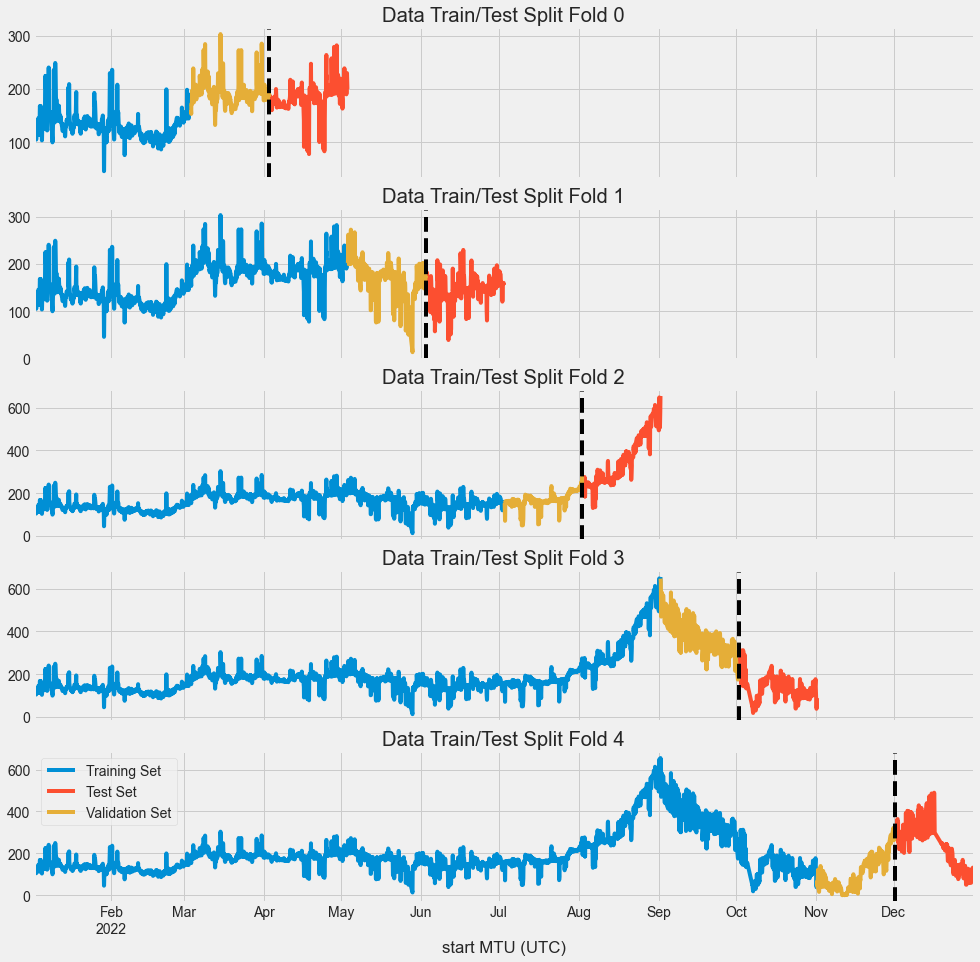

In [391]:
# use a 5-fold cross-validation with each fold representing a period of approximately 73 days.
times_series = TimeSeriesSplit(n_splits=5, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
preds = []
scores = []
for train_idx, val_idx in times_series.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    val_data, test = train_test_split(test, test_size=0.5, shuffle=False)

    # Train dataset
    X_train = train[FEATURES]
    y_train = train[TARGET]

    ## Test dataset, used for predicting
    X_test = test[FEATURES]
    y_test = test[TARGET]

    # used for eval_set()
    X_valid= val_data[FEATURES]
    y_valid = val_data[TARGET]

    default_reg = xgb.XGBRegressor (
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=4,
        scale_pos_weight=1,
        seed=27)

    ## Fit the model using train data and do simple evaluation using validation set
    history = default_reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric = 'rmse',
            verbose=False)
    # Access the performance metrics
    train_scores = history.evals_result()['validation_0']['rmse']
    valid_scores = history.evals_result()['validation_1']['rmse']

    # Print the performance metrics at the last epoch
    print(f"Train RMSE: {train_scores[-1]:.2f}")
    print(f"Valid RMSE: {valid_scores[-1]:.2f}")


    ### Forecast using the test data
    """
    y_pred = default_reg.predict(X_test)
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
"""

    train[TARGET].plot(ax=axs[fold],
                        label='Training Set')

    test[TARGET].plot(ax=axs[fold],
                        label='Test Set')

    val_data[TARGET].plot(ax=axs[fold],
                        label='Validation Set',
                        title=f'Data Train/Test Split Fold {fold}')

    axs[fold].axvline(test.index.min(), color='black', ls='--')


    fold += 1

# Print the performance metrics at the last epoch for fitting and evaluation
print("*  fitting and evaluation train scores :", train_scores[::200])
print("*  fitting and evaluation valid_scores :" ,valid_scores[::200])

# Print the performance metrics at the last epoch for predicting test_data
print("*  predicting test_predict_scores :" ,scores[::200])

plt.legend(loc="best")
plt.show()



In [392]:
print("Train set :", train.shape, ". Which is almost 305 days from 365 days")
print("Test set :", test.shape, ". Which is almost 30 days from 365 days")
print("Test set :", val_data.shape, ". Which is almost 30 days from 365 days")

Train set : (7280, 900) . Which is almost 305 days from 365 days
Test set : (728, 900) . Which is almost 30 days from 365 days
Test set : (727, 900) . Which is almost 30 days from 365 days


# Trying to do multistep forecasting.

For each row in the test set, the code predicts the target variable 24 hours into the future using the current features and the lagged target variables. The predicted value is then added to the lagged target variables of the current row, so that the prediction can be used as input for the next prediction

C:\Users\Isak\AppData\Local\Temp\ipykernel_26092\90189154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.iloc[i, -n_steps:] = np.append(X_test.iloc[i, -(n_steps-1):].values, y_pred[0])


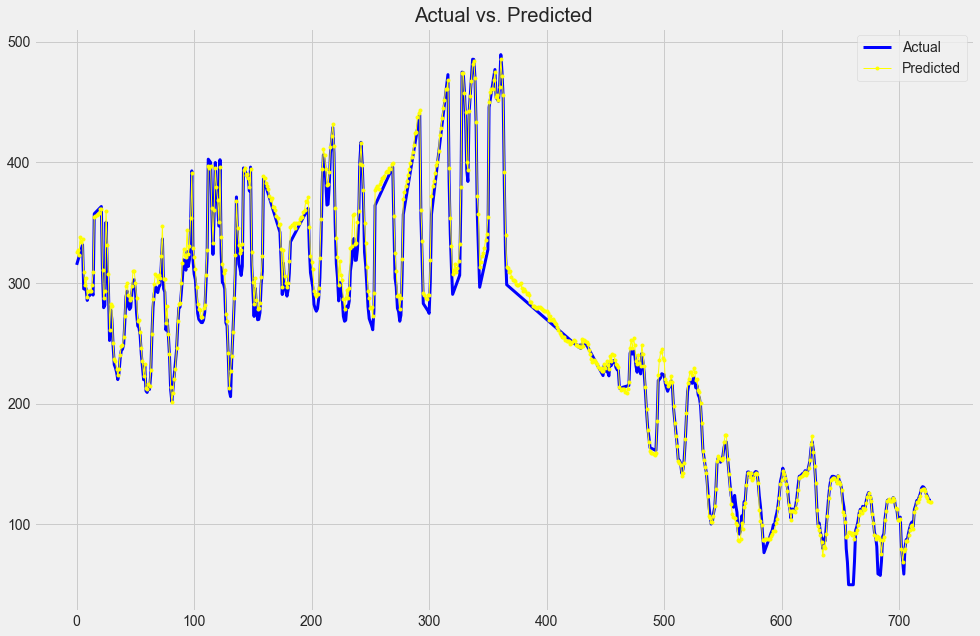

RMSE for multistep forecasting: 8.915636942142296
Mean absolute error for multistep forecasting on test set:  6.436364630474536
Mean squared error for multistep forecasting on test set: 79.48858208409244


In [393]:

from sklearn.metrics import mean_squared_error

n_steps = 24
# Make predictions
predictions = []
for i in range(len(X_test)):
    x = X_test.iloc[i]
    y_pred = default_reg.predict(x.values.reshape(1, -1))
    predictions.append(y_pred[0])
    X_test.iloc[i, -n_steps:] = np.append(X_test.iloc[i, -(n_steps-1):].values, y_pred[0])

y_test = np.array(y_test)
predictions = np.array(predictions)

import matplotlib.pyplot as plt

# Plot the predicted and actual values
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(y_test, color='blue', label='Actual', lw=3 )
ax.plot(predictions, color='yellow', label='Predicted', lw=1, marker='.')
ax.legend()
ax.set_title('Actual vs. Predicted')
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)
plt.show()


# Calculate the root mean squared error (RMSE)
rmse = (mean_squared_error(y_test, predictions, squared=False))
print(f'RMSE for multistep forecasting: {rmse}')

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_test_data1 = mean_absolute_error(y_test, predictions)
print("Mean absolute error for multistep forecasting on test set: ", mae_test_data1)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_test_data1 = mean_squared_error(y_test, predictions)
print("Mean squared error for multistep forecasting on test set:", mse_test_data1)


### Predict test _scores

In [394]:
print(f'* RMSE scores for each fold , when predicting test data:{scores}')
print()
print(f'* Average/mean RMSE Score across folds for test_data : {np.mean(scores):0.4f}')
print()


* RMSE scores for each fold , when predicting test data:[]

* Average/mean RMSE Score across folds for test_data : nan



C:\Users\Isak\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Isak\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Testing lagged_features for a limited time frame

In [395]:
df_limited = df.loc[ '2022-12-29' : '2022-12-31']
df.index

DatetimeIndex(['2022-01-02 00:00:00', '2022-01-02 01:00:00',
               '2022-01-02 02:00:00', '2022-01-02 03:00:00',
               '2022-01-02 04:00:00', '2022-01-02 05:00:00',
               '2022-01-02 06:00:00', '2022-01-02 07:00:00',
               '2022-01-02 08:00:00', '2022-01-02 09:00:00',
               ...
               '2022-12-31 13:00:00', '2022-12-31 14:00:00',
               '2022-12-31 15:00:00', '2022-12-31 16:00:00',
               '2022-12-31 17:00:00', '2022-12-31 18:00:00',
               '2022-12-31 19:00:00', '2022-12-31 20:00:00',
               '2022-12-31 21:00:00', '2022-12-31 22:00:00'],
              dtype='datetime64[ns]', name='start MTU (UTC)', length=8735, freq=None)

In [396]:
# Function to create lagged dataset wit 24 lag features for each input feature
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()

    # Adding lagged features for target variable
    lagged_df['Day-ahead Price _EUR/MWh_ BZN|NO1'] = lagged_df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(-1)

    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)

    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(25)], axis=1)

    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)

    return lagged_df

# 4. Training Model

We have to remove all symbols from feature names , otherwise get the following error :

"  ValueError: feature_names must be string, and may not contain [, ] or <  "


### Simple regressor and parameters

In [397]:
"""
## (0.10812,3.69 )
basic_reg = xgb.XGBRegressor (
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=27)

### (0.08, 3,23) second , best
 = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01)
"""

"\n## (0.10812,3.69 )\nbasic_reg = xgb.XGBRegressor (\n    learning_rate =0.1,\n    n_estimators=1000,\n    max_depth=5,\n    min_child_weight=1,\n    gamma=0,\n    subsample=0.8,\n    colsample_bytree=0.8,\n    nthread=4,\n    scale_pos_weight=1,\n    seed=27)\n\n### (0.08, 3,23) second , best\n = xgb.XGBRegressor(\n    base_score=0.5,\n    booster='gbtree',\n    n_estimators=1000,\n    early_stopping_rounds=50,\n    objective='reg:squarederror',\n    max_depth=3,\n    learning_rate=0.01)\n"

In [398]:
# start timer
start_time = time.time()
end_time = time.time()
#print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 0.00 seconds


### Feature Importance


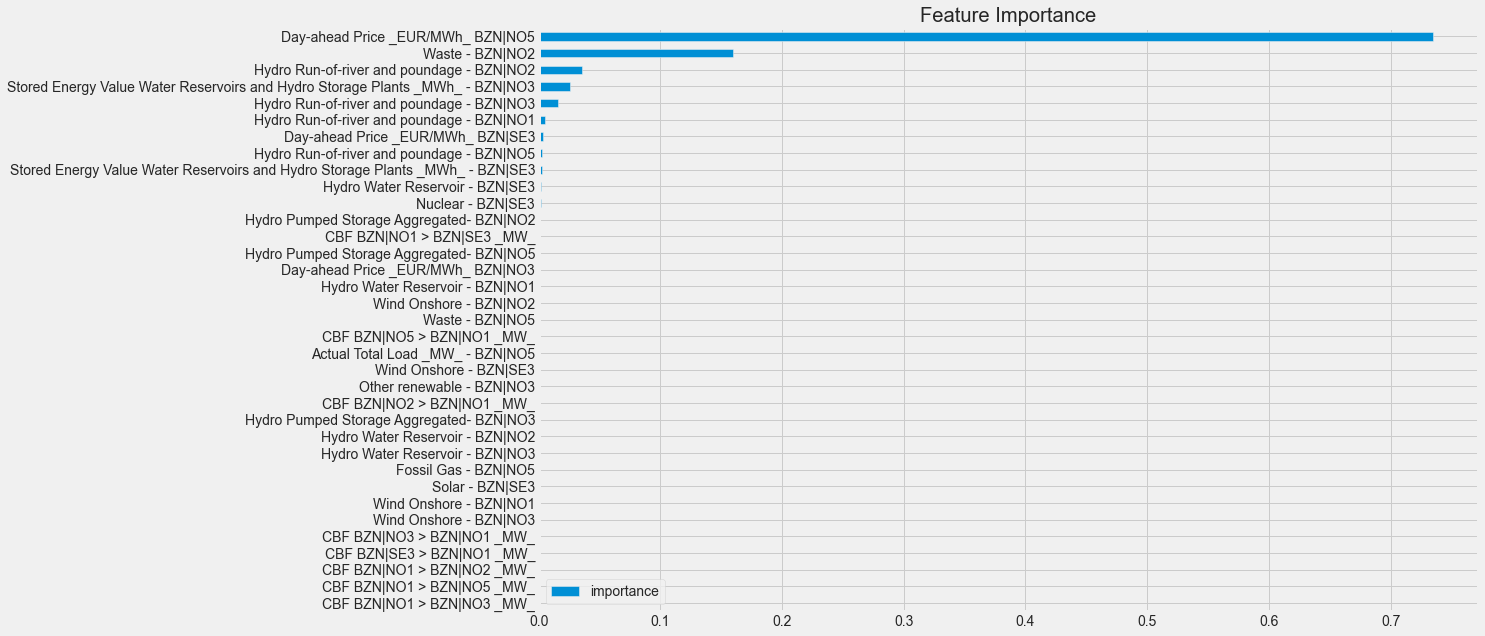

In [399]:
fi = pd.DataFrame(data=default_reg.feature_importances_,
             index=default_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize= (15,10))
plt.show()

### Forecast on validation data


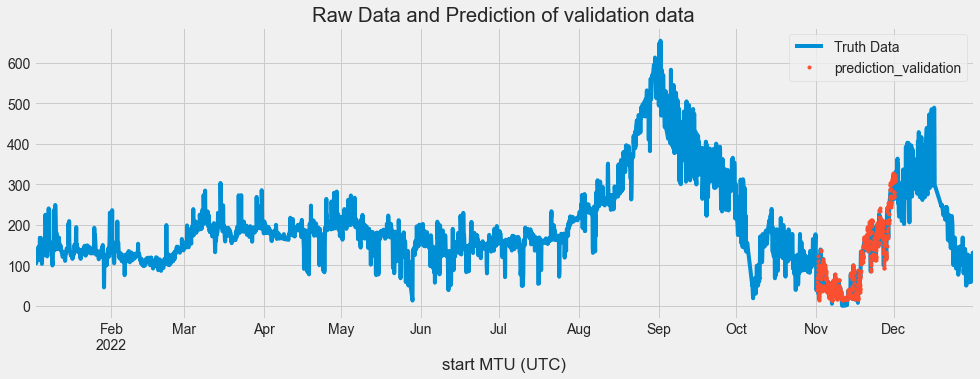

In [400]:
val_data['prediction_validation'] = default_reg.predict(X_valid)
df = df.merge(val_data[['prediction_validation']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_validation'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_validation'])
ax.set_title('Raw Data and Prediction of validation data')
plt.show()

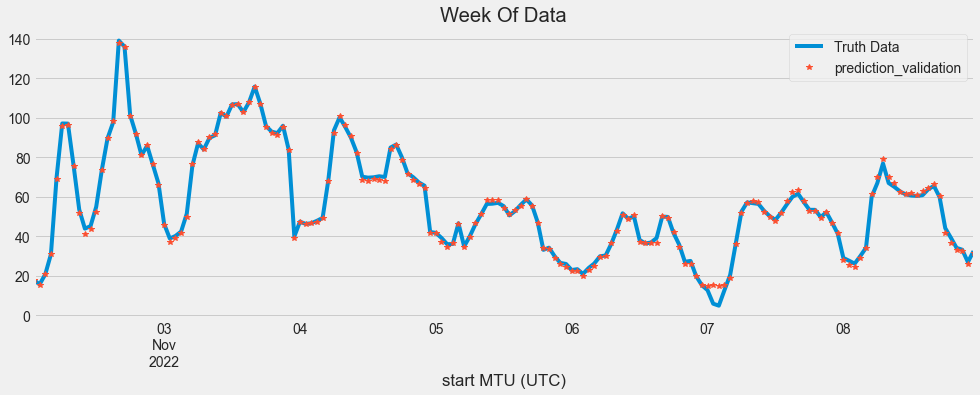

In [401]:
ax = df.loc[(df.index > '2022-11-02') & (df.index < '2022-11-09')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2022-11-02') & (df.index < '2022-11-09')]['prediction_validation'] \
    .plot(style='*')
plt.legend(['Truth Data','prediction_validation'])
plt.show()


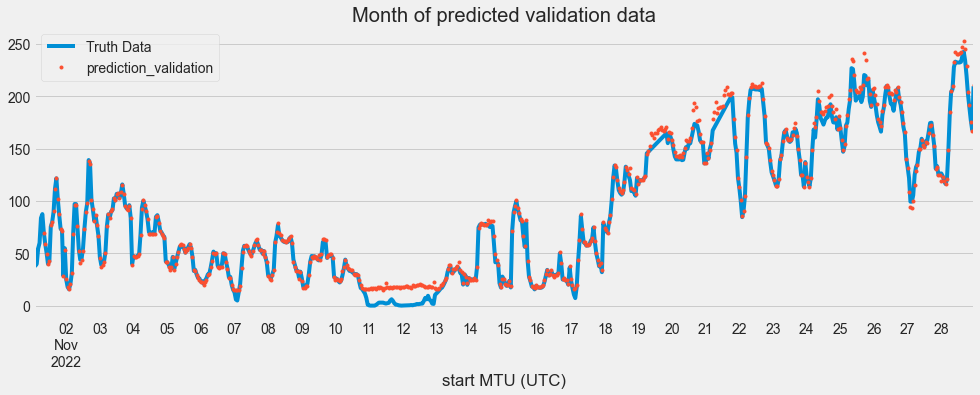

In [402]:
_ax = df.loc[(df.index > '2022-11-01') & (df.index < '2022-11-29')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Month of predicted validation data')
df.loc[(df.index > '2022-11-01') & (df.index < '2022-11-29')]['prediction_validation'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_validation'])
plt.show()

### Score on validation data

In [403]:
score_val_data = np.sqrt(mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation']))
print(f'RMSE Score on valid set: {score:0.2f}')


# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_val_data = mean_absolute_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean absolute error on valid set: ", mae_val_data)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_val_data = mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean squared error on valid set: ", mse_val_data)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse_val_data = math.sqrt(mse_val_data)
print("Root mean squared error on valid set: ", rmse_val_data)

RMSE Score on valid set: 14.63
Mean absolute error on valid set:  4.203605414525678
Mean squared error on valid set:  51.06099299308294
Root mean squared error on valid set:  7.145697516203925


In [404]:
response_range = val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].max() - val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].min()

# Determine if the RMSE value is a good fit
if rmse_val_data < 0.1 * response_range:
    print("The RMSE value of", rmse_val_data, "is a good fit for this time series regression model. When the response range is :", response_range)
else:
    print("The RMSE value of", rmse_val_data, "indicates poor performance for this time series regression model. When the response range is :", response_range)


The RMSE value of 7.145697516203925 is a good fit for this time series regression model. When the response range is : 320.64


### MAPE

In [405]:
mean_absolute_percentage_error(y_true=val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'],
                               y_pred=val_data['prediction_validation'])

2.992733590923265

### Forecast on Test data

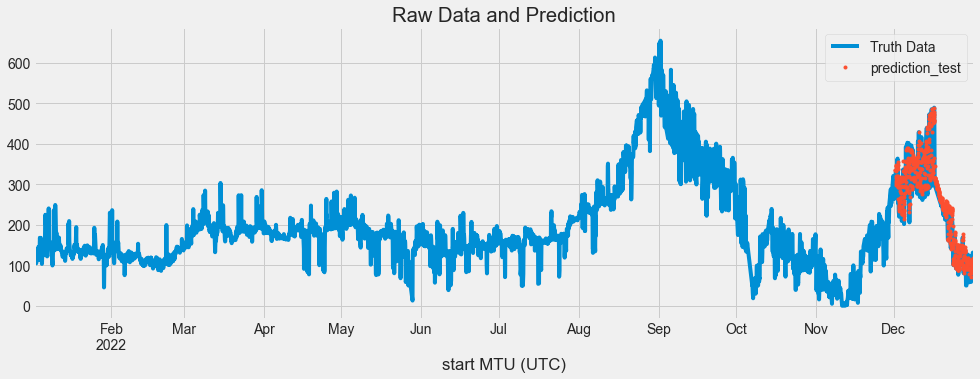

In [406]:
test['prediction_test'] = default_reg.predict(X_test)
df = df.merge(test[['prediction_test']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_test'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_test'])
ax.set_title('Raw Data and Prediction')
plt.show()

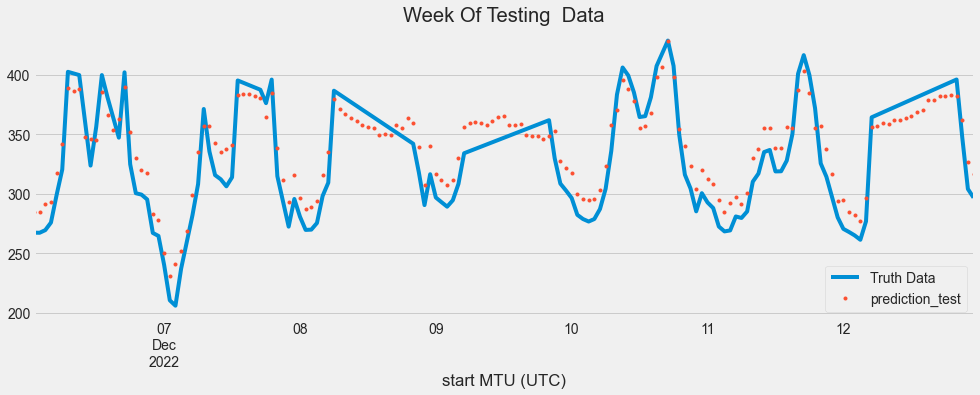

In [407]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Testing  Data')
df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()



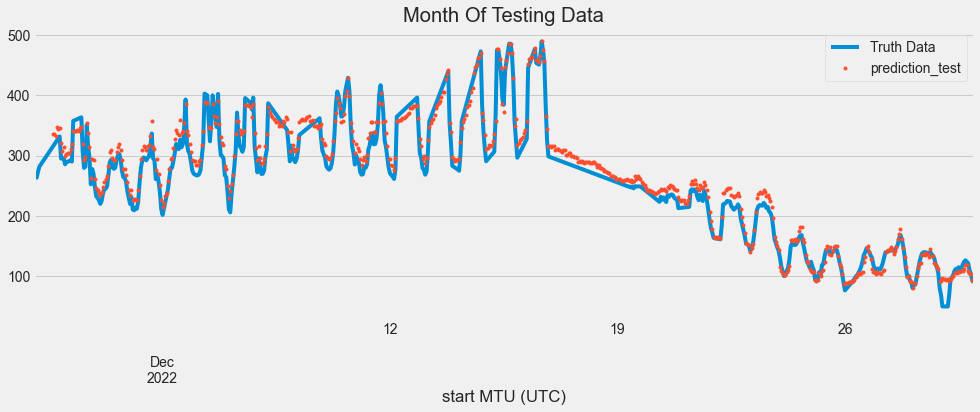

In [408]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Month Of Testing Data')
df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()

### Score on test

In [409]:
score = np.sqrt(mean_squared_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test']))
print(f'RMSE Score on test set: {score:0.2f}')


# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_test_data = mean_absolute_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test'])
print("Mean absolute error on test set: ", mae_test_data)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_test_data = mean_squared_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test'])
print("Mean squared error on test set:", mse_test_data)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse_test_data = math.sqrt(mse_test_data)
print("root mean squared error on test set: ", rmse_test_data)

RMSE Score on test set: 14.63
Mean absolute error on test set:  12.41501834702105
Mean squared error on test set: 213.99514684372895
root mean squared error on test set:  14.6285729599209


### MAPE

In [410]:
mean_absolute_percentage_error(y_true=test['Day-ahead Price _EUR/MWh_ BZN|NO1'],
                               y_pred=test['prediction_test'])

0.05845837410759369

In [411]:
response_range_test_data = test['Day-ahead Price _EUR/MWh_ BZN|NO1'].max() - test['Day-ahead Price _EUR/MWh_ BZN|NO1'].min()

# Determine if the RMSE value is a good fit
if rmse_test_data < 0.1 * response_range_test_data:
    print("The RMSE value of", rmse_test_data, "is a good fit for this time series regression model. When the response range is :", response_range_test_data)
else:
    print("The RMSE value of", rmse_test_data, "indicates poor performance for this time series regression model. When the response range is :", response_range_test_data)


The RMSE value of 14.6285729599209 is a good fit for this time series regression model. When the response range is : 439.31


# Calculate Error
- Look at the worst and best predicted days


In [412]:
test['error'] = np.abs(test[TARGET] - test['prediction_test'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-12-11    18.499940
2022-12-07    17.802502
2022-12-05    17.659352
2022-12-06    17.560720
2022-12-01    17.525558
2022-12-04    16.705270
2022-12-09    16.152813
2022-12-02    16.056256
2022-12-17    15.851010
2022-12-03    14.511170
Name: error, dtype: float64

# 5. Predicting 24 hours time horizon